In [1]:
!pip install --quiet yfinance

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# Define your portfolio and data range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
weights = np.array([0.25, 0.25, 0.25, 0.25])  # equal-weight portfolio

start = dt.datetime(2021, 1, 1)
end = dt.datetime.today()

# Containers for adjusted close prices
prices = pd.DataFrame()

for ticker in tickers:
    print(f"Fetching {ticker}...", end="")
    try:
        df = yf.Ticker(ticker).history(
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
        )
        series = df['Close']  # Ensure correct column name
        print(" ✓ yfinance", end=" ")
    except Exception as e:
        print(f" ✕ yfinance ({e}); falling back to stooq", end="")
        df2 = pdr.DataReader(ticker, 'stooq', start, end)
        df2 = df2.sort_index()
        series = df2['Close']
    prices[ticker] = series
    time.sleep(1)  # Pause to respect rate limits
    print()

# Drop leading NaNs if any, then forward-fill/back-fill gaps
prices = prices.dropna(how='all').ffill().bfill()

# Quick sanity check
print(prices.tail())


Fetching AAPL... ✓ yfinance 
Fetching MSFT... ✓ yfinance 
Fetching GOOGL... ✓ yfinance 
Fetching AMZN... ✓ yfinance 
                                 AAPL        MSFT       GOOGL        AMZN
Date                                                                     
2025-06-23 00:00:00-04:00  201.500000  486.000000  165.190002  208.470001
2025-06-24 00:00:00-04:00  200.300003  490.109985  166.770004  212.770004
2025-06-25 00:00:00-04:00  201.559998  492.269989  170.679993  211.990005
2025-06-26 00:00:00-04:00  201.000000  497.450012  173.539993  217.119995
2025-06-27 00:00:00-04:00  201.080002  495.940002  178.529999  223.300003


In [4]:
# Log-return = Ln(P_t / P_{t-1})
logR = np.log(prices / prices.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2021-01-05 00:00:00-05:00,0.012288,0.000964,0.008032,0.009955
2021-01-06 00:00:00-05:00,-0.034241,-0.026271,-0.009917,-0.025212
2021-01-07 00:00:00-05:00,0.033554,0.028060,0.029431,0.007549
2021-01-08 00:00:00-05:00,0.008594,0.006074,0.013152,0.006475
2021-01-11 00:00:00-05:00,-0.023524,-0.009746,-0.023377,-0.021754


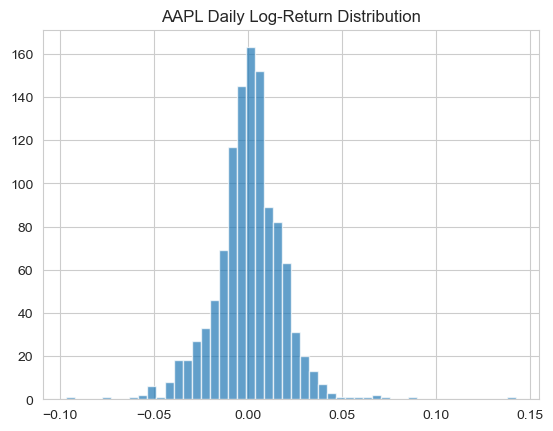

In [5]:
# Plot one example series for visiual check
# You'll see a bell shaped histogram
logR['AAPL'].hist(bins=50, alpha=0.7)
plt.title("AAPL Daily Log-Return Distribution")
plt.show()

In [6]:
summary = pd.DataFrame({
    'Mean': logR.mean(),
    'Variance': logR.var(),
    'Skewness': logR.skew(),
    'Kurtosis': logR.kurtosis()
})
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000414,0.000320,0.238934,5.532339
MSFT,0.000765,0.000277,0.076887,2.871090
GOOGL,0.000651,0.000392,-0.128536,3.019270
AMZN,0.000300,0.000503,-0.097553,5.073721


In [7]:
# Fit Normal : mean µ, std ⍺
mu_norm, sigma_norm = logR.stack().mean(),logR.stack().std(ddof=1)

# 95% CI for mean under Normal:µ + z*.⍺/✓N
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95*sigma_norm/np.sqrt(N),
              mu_norm + z95*sigma_norm/np.sqrt(N))

# 95% CI for ⍺ via Chi-square:
df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025,0.975],df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))

print("Normal fit:")
print(f" µ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f" ⍺ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal fit:
 µ = 0.00053, 95% CI (-3.163884397439055e-05, 0.0010969956593015178)
 ⍺ = 0.01931, 95% CI (0.01892348213992987, 0.019721952685680045)


In [8]:
# Fit Student's t

# Fit t-distribution to the pooled returns
# return_flat = all asset returns concatenated

returns_flat = logR.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

In [9]:
# 95% CI for µ and ⍺ of a t-fit is more complex; we can bootstrap them:
B = 1000
estimates = np.array([stats.t.fit(np.random.choice(returns_flat, size=N, replace=True))
                      for _ in range(B)])
ci_mu_t = np.percentile(estimates[:,1], [2.5,97.5])
ci_sigma_t = np.percentile(estimates[:,2], [2.5,97.5])

print("\nStudent's t fit:")
print(f" df = {df_t:1f}, µ = {mu_t:.5f}, ⍺ = {sigma_t:.5f}")
print(f" 95% for µ (bootstrap): {ci_mu_t}")
print(f" 95% for ⍺ (bootstrap): {ci_sigma_t}")


Student's t fit:
 df = 4.159386, µ = 0.00083, ⍺ = 0.01408
 95% for µ (bootstrap): [0.00036473 0.0012895 ]
 95% for ⍺ (bootstrap): [0.01351106 0.01462199]


In [10]:
# Parametric VaR under Normal
# VaR = - [µ_p + ⍺_p . z_{0.05}]
# Where µ_p, ⍺_p are portfolio mean & vol.
# Compute portfolio returns:

portR = logR.dot(weights)
µ_p = portR.mean()
a_p = portR.std(ddof=1)

z05 = stats.norm.ppf(0.05)
VaR_norm = -(µ_p + a_p * z05)

In [11]:
# Parametric VaR under Student's t:
#  t05 = t.ppf(0.05, df_t)
t05 = stats.t.ppf(0.05, df_t)
VaR_t = - (mu_t + sigma_t * t05) *1 # 1-day

In [12]:
# Histrocial VaR (non-parametric):
hist_var = -np.percentile(portR, 5)

print("1-Day 95% VaR:")
print(f" Parametric (Normal): {VaR_norm:.5f}")
print(f" Parametric (Student's t): {VaR_t:.5f}")
print(f" Histrocial (5th percentile): {hist_var:.5f}")

1-Day 95% VaR:
 Parametric (Normal): 0.02647
 Parametric (Student's t): 0.02885
 Histrocial (5th percentile): 0.02718


In [13]:
# One-sample t-test: H0: µ=0 vs H1: µ ≠ 0
t_stat, p_val = stats.ttest_1samp(portR, 0.0)
print("One-sample t-test on portfolio daily returns:")
print(f" t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

if p_val < 0.05:
    print(" -> Reject H0: mean return is significantly different from zero.")
else:
    print(" -> Fail to reject H0: no evidence mean return ≠ 0.")

One-sample t-test on portfolio daily returns:
 t-statistic = 1.088, p-value = 0.277
 -> Fail to reject H0: no evidence mean return ≠ 0.


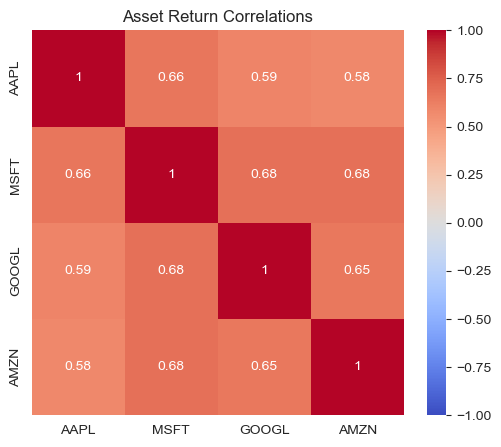

Weighted avg σ: 0.0192
Actual portfolio σ: 0.0164
Diversification benefit: 0.0028


In [14]:
# Correlation heatmap
corr = logR.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Asset Return Correlations')
plt.show()

# b) Diversification benefit
o_i = logR.std()  # Individual volatilities
a_weighted = np.dot(weights, o_i)  # Naive weighted average
o_portfolio = logR.dot(weights).std()  # Actual portfolio volatility

print(f"Weighted avg σ: {a_weighted:.4f}")
print(f"Actual portfolio σ: {o_portfolio:.4f}")
print(f"Diversification benefit: {a_weighted - o_portfolio:.4f}")


Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


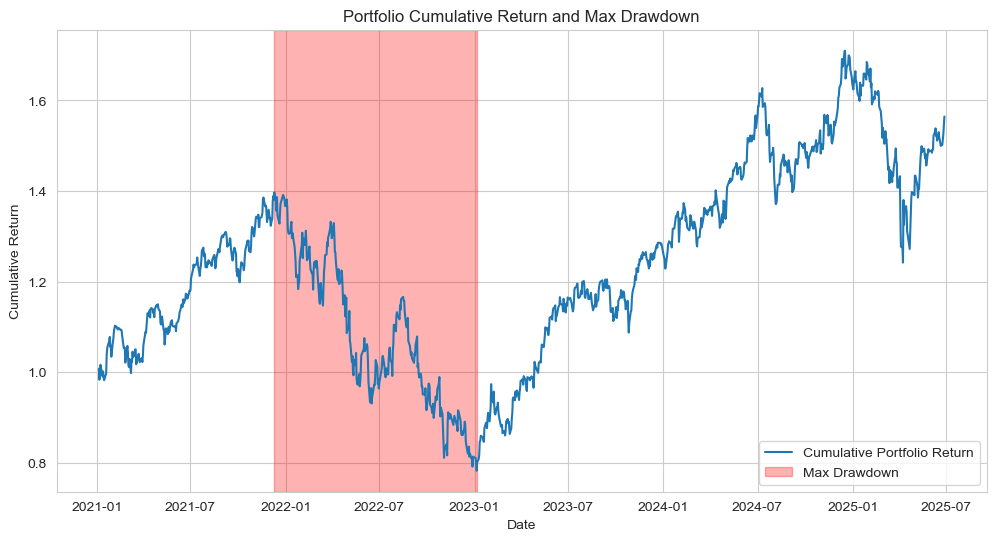

In [15]:
# Cumulative returns
cum_port = (portR + 1).cumprod()

# Drawdown calculation
rolling_max = cum_port.cummax()
drawdown = (cum_port - rolling_max) / rolling_max
max_dd = drawdown.min()

# Drawdown period
end_date = drawdown.idxmin()
start_date = cum_port.loc[:end_date].idxmax()  # Most recent peak before drawdown bottom

print(f"Max Drawdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cum_port, label='Cumulative Portfolio Return')
plt.axvspan(start_date, end_date, color='red', alpha=0.3, label='Max Drawdown')
plt.title('Portfolio Cumulative Return and Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
alpha = 0.05  # 95% confidence level

# Historical Expected Shortfall
es_hist = portR[portR <= np.percentile(portR, 100 * alpha)].mean()

# Parametric Normal ES
mu_pop = portR.mean()
sigma_pop = portR.std()
z = stats.norm.ppf(alpha)  # ≈ -1.645
es_norm = - (mu_pop - sigma_pop * stats.norm.pdf(z) / alpha)  # Note: minus sign for loss measure

print(f"Historical ES (95%): {es_hist:.5f}")
print(f"Parametric Normal ES (95%): {es_norm:.5f}")


Historical ES (95%): -0.03722
Parametric Normal ES (95%): 0.03333


In [17]:
# VaR Backtesting
var_series =  -(portR.rolling(1).mean()+ portR.rolling(1).std()*z05)

#For simplicity use constant Var norm
exceptions =  portR < -VaR_norm
num_exc =  exceptions.sum()
total =  len(portR)

print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 63/1125 days (5.60%, expected ~5%)


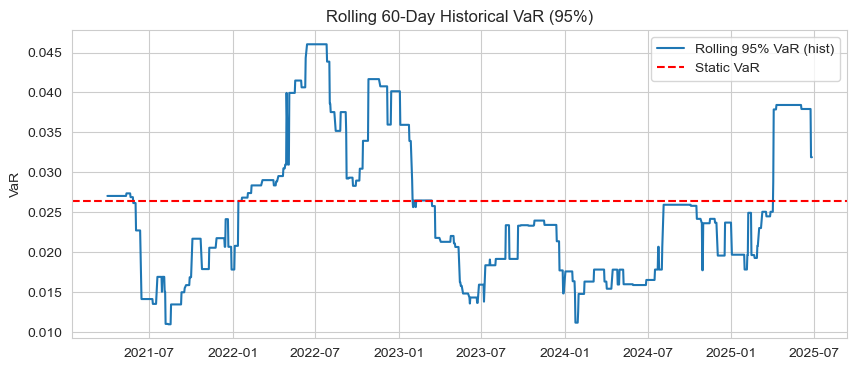

In [18]:
# Rolling 60-day VaR

window = 60
roll_var =  portR.rolling (window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(VaR_norm, color='red', linestyle = '--', label='Static VaR')
plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

In [19]:
from scipy import stats

jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p:.3f}")

if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")


JB statistic = 514.56, p-value = 0.000
Reject normality at 5% level.
